# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
from omegaconf import OmegaConf
%load_ext autoreload
%autoreload 2

import breaching

import copy
import matplotlib.pyplot as plt 

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=invertinggradients',
                                                      'case=1_single_image_small'])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
    print('Attack settings are:')
    print(OmegaConf.to_yaml(cfg.attack))
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_image_small with server type honest_but_curious.
Attack settings are:
type: invertinggradients
attack_type: optimization
objective:
  type: cosine-similarity
  scale: 1.0
restarts:
  num_trials: 1
  scoring: cosine-similarity
init: randn
optim:
  optimizer: adam
  signed: true
  step_size: 0.1
  boxed: true
  max_iterations: 24000
  step_size_decay: step-lr
  langevin_noise: 0.0
  warmup: 0
  callback: 1000
regularization:
  total_variation:
    scale: 0.2
    inner_exp: 1
    outer_exp: 1
  orthogonality:
    scale: 0.0



{'device': device(type='cuda'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [25]:
cfg.case.user.data_idx = 0
cfg.case.model='convnet-trivial'

cfg.case.user.num_data_points=1


cfg.case.server.model_state = 'untrained'

# The total variation scale should be small for CIFAR images
cfg.attack.regularization.total_variation.scale = 1e-6

cfg.attack.objective.type = 'cosine-similarity'
cfg.attack.objective.scale = 1
cfg.attack.optim.signed=False

### Instantiate all parties

In [26]:
user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)

Files already downloaded and verified
Model architecture <class 'torch.nn.modules.container.Sequential'> loaded with 116,746 parameters and 0 buffers.
Overall this is a data ratio of      38:1 for target shape [1, 3, 32, 32] given that num_queries=1.


In [27]:
print(user)
print(server)
print(attacker)

server.model.to(**setup)

User (of type UserSingleStep with settings:
            number of local updates: 1
            number of data points: 1
            number of user queries 1

            Threat model:
            User provides labels: True
            User provides number of data points: True

            Model:
            model specification: Sequential
            loss function: CrossEntropyLoss()

            Data:
            Dataset: CIFAR10
            data_idx: 0
        


Sequential(
  (conv): Conv2d(3, 3072, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (pool): AdaptiveAvgPool2d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=3072, out_features=10, bias=True)
)

### Simulate an attacked FL protocol

True user data is returned only for analysis

In [28]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  

In [29]:
[(g.mean(), g.std()) for g in shared_data['gradients'][0]]

[(tensor(1.6781e-06, device='cuda:0'), tensor(0.0018, device='cuda:0')),
 (tensor(7.2450e-05, device='cuda:0'), tensor(0.0052, device='cuda:0')),
 (tensor(2.7643e-10, device='cuda:0'), tensor(0.0590, device='cuda:0')),
 (tensor(2.9802e-09, device='cuda:0'), tensor(0.3186, device='cuda:0'))]

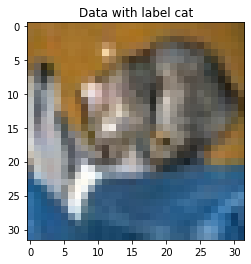

In [30]:
user.plot(true_user_data)

### Reconstruct user data:

In [31]:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, 
                                                      server.secrets, dryrun=cfg.dryrun)

It: 1. Rec. loss: 0.0897. T: 0.01s
It: 1001. Rec. loss: 0.0000. T: 5.94s
It: 2001. Rec. loss: 0.0000. T: 5.95s
It: 3001. Rec. loss: 0.0000. T: 5.99s
It: 4001. Rec. loss: 0.0000. T: 5.96s
It: 5001. Rec. loss: 0.0000. T: 6.03s
It: 6001. Rec. loss: 0.0001. T: 5.95s
It: 7001. Rec. loss: 0.0000. T: 6.04s
It: 8001. Rec. loss: 0.0000. T: 5.94s
It: 9001. Rec. loss: 0.0000. T: 6.01s
It: 10001. Rec. loss: 0.0000. T: 5.93s
It: 11001. Rec. loss: 0.0000. T: 5.96s
It: 12001. Rec. loss: 0.0000. T: 5.97s
It: 13001. Rec. loss: 0.0000. T: 5.99s
It: 14001. Rec. loss: 0.0000. T: 5.96s
It: 15001. Rec. loss: 0.0000. T: 6.07s
It: 16001. Rec. loss: 0.0000. T: 6.00s
It: 17001. Rec. loss: 0.0000. T: 5.96s
It: 18001. Rec. loss: 0.0000. T: 6.01s
It: 19001. Rec. loss: 0.0000. T: 5.97s
It: 20001. Rec. loss: 0.0000. T: 5.93s
It: 21001. Rec. loss: 0.0000. T: 5.99s
It: 22001. Rec. loss: 0.0000. T: 6.01s
It: 23001. Rec. loss: 0.0000. T: 5.99s
It: 24000. Rec. loss: 0.0000. T: 5.93s
Optimal condidate solution with rec. l

In [32]:
# How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, user.dataloader, setup, order_batch=False)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/jonas/miniconda3/envs/dl/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
METRICS: | MSE: 0.0471 | PSNR: 13.27 | FMSE: 4.7858e-08 | LPIPS: 0.07| R-PSNR: 13.27 | IIP:   0.00%


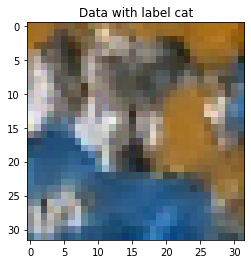

In [33]:
user.plot(reconstructed_user_data)

In [22]:
# How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, user.dataloader, setup, order_batch=True)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/jonas/miniconda3/envs/dl/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
METRICS: | MSE: 0.0517 | PSNR: 12.87 | FMSE: 1.1182e-07 | LPIPS: 0.09| R-PSNR: 12.87 | IIP:   0.00%


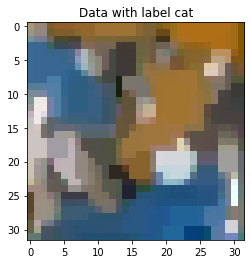

In [24]:
user.plot(reconstructed_user_data)

PSNR without parameter modifications and 10 data points: 16-17